In [ ]:
 import tensorflow as tf
 from keras.models import *
 from keras.layers import *
 from keras.datasets import imdb
 from keras.utils import pad_sequences


## Define the transforms block

In [ ]:
class TransformersBlock(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
     # embed_dim: this parameter specifies the dimensionality of the input and output embeddings.
     # num_heads: this parameter controls the number of attention heads in the multi-head attendtion.
     # ff_dim: This parameter specifies the dimensionality of the feedforward network
     # rate: This parameter controls the dropout rate, which is used to regularize

    super().__init__()
    self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    # This creates a MultiHeadAttention layer, responsible for learning long-range dependencies
    self.ffn = Sequential(
        [Dense(ff_dim, activation="relu"), Dense(embed_dim),])
    #self.ffn: This creates a feedforward network, often used for additional normalization
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    #self.layernorm1 and layer2: These create LayerNormalization layers
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)
    #Dropouts create randomly setting

  def call(self, inputs, training):
    attn_output = self.att(inputs, inputs)
    #Applies multihead attention to the input sequence, allowing different parts of the sentence to be learnt parallely
    attn_output = self.dropout1(attn_output, training=training)
    #Applies dropout to the attention output
    out1 = self.layernorm1(inputs + attn_output)
    #Adds layer normalization to the input and attention output
    ffn_output = self.ffn(out1)
    #Applies feedforward network to the output of layer normalization
    ffn_output = self.dropout2(ffn_output, training=training)
    #Applies dropout to the feedforward network output
    return self.layernorm2(out1 + ffn_output)
    #Adds layer normalization to the output of the feedforward network


In [ ]:
class TokenAndPositionEmbedding(Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    #maxlen: The maximum length of the input sequence
    #vocab_size: The size of the vocabulary (unique tokens in the vocabulary)
    #embed_dim: The dimensionality of the embeddings (how each token and its position...
    super().__init__()
    self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    #This creates an embedding layer for token (maps each token in the input sequence)
    #to a dense vector of size embed_dim
    self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
    #This creates an embedding layer for position (maps each position in the input sequence)
    #from 0 to maxlen-1 to a dense vector of size embed_dim

  def call(self,x):
    maxlen = tf.shape(x)[-1]
    #Extracts the actual length of the current input sequence
    positions = tf.range(start=0, limit=maxlen, delta=1)
    #Create a tensor of positions from 0 to maxlen-1
    positions = self.pos_emb(positions)
    #Looks up the position embeddings for each position in the sequence
    x = self.token_emb(x)
    #Looks up the token embeddings for each token in the input sequence
    return x + positions
    #Adds the position embeddings to the token embeddings (element wise)
    #meaning and positional information

In [ ]:
vocab_size = 20000  #considering top 20k words
maxlen = 200 #considering first 200 words for each movie review

In [ ]:
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

25000 Training sequences
25000 Validation sequences


In [ ]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

In [ ]:
x_train.shape

(25000, 200)

In [ ]:
x_train[400]

array([ 1643,   723,  1342,    36,    80,  4487,     9,     4,     2,
       11181,    10,    10,   103,     4,  1496,     4,  2179,  1974,
          15,    50,    16,    57,   194,  1922,  2277,    11,     4,
        1513,    40,    68,  1172,     2,   579,    98,    38,    11,
           4,   130,    12,    16,   371,     6,   379,  4271,   823,
           4,   888,     9,   138,   122,    36,    81,    12,     5,
          14,     9,   142,     4,   333,   320,     7,     4,    22,
        5644,    11,  1137,    12,   304,    35,   534,     5,     6,
         320,    83,     4,    20,   159,     4,  5928,  1277,    56,
          19,     4,  2179,     5,   895,     4, 13121,    10,    10,
          45,   134,   477,   139,    15,  1671,     4,    91,  5380,
           5,     4,    91,   602,    17,     4,  1013,    26,   579,
        2041,    93,  1942,  2497,     5,   317,     6,   581,  2413,
           4,   779,   687,    56,     8,     5,   587,     4,   588,
          26,  1894,

**Combine** all together

In [ ]:
embed_dim = 32 #size for each token
num_heads = 2  #attention heads
ff_dim = 32    #Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen, ))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformersBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 32)           646400    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformers_block (Transf  (None, 200, 32)           10656     
 ormersBlock)                                                    
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

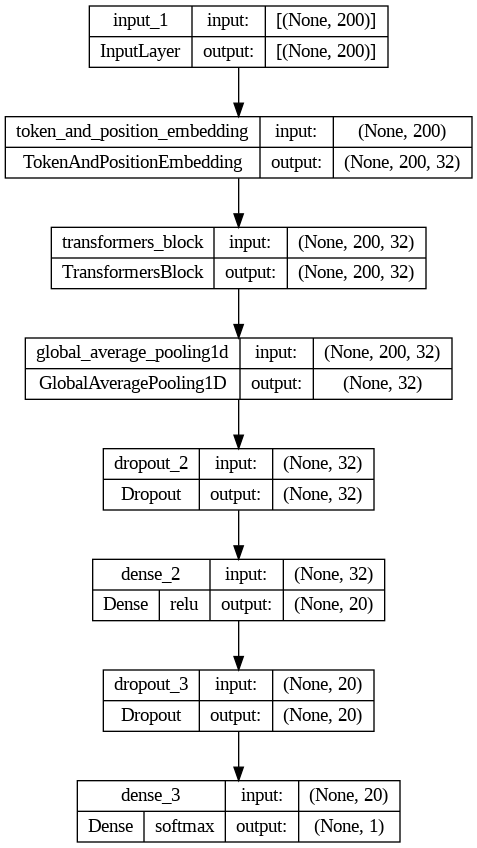

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True)

Compile the model

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
782/782 [==============================] - 82s 85ms/step - loss: nan - accuracy: 0.5001 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/10
782/782 [==============================] - 24s 31ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
782/782 [==============================] - 17s 21ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/10
782/782 [==============================] - 14s 18ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/10
782/782 [==============================] - 11s 14ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/10
782/782 [==============================] - 13s 17ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/10
782/782 [==============================] - 11s 14ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 8/10
782/782 [==============